In [45]:
import sys
sys.path.append('../')

import pandas as pd 
import numpy as np
import json
import seaborn as sns 

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.metrics import euclidean_distances
from sklearn.feature_selection import VarianceThreshold

from scipy.spatial import distance
from scipy.stats import norm

from rdkit import Chem
from rdkit.Chem.rdChemReactions import CreateDifferenceFingerprintForReaction
from rdkit.Chem import rdChemReactions


import dft_descriptors.featurisation as ft
import dft_descriptors.prepocessing as pp
from dft_descriptors.featurisation import process_dataframe_dft

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.transforms as transforms


def AL_preprocess(df):
    df["Lewis Acid"] = df["Lewis Acid"].fillna('NoLewisAcid')
    df["Lewis Acid"] = df["Lewis Acid"].replace('nan', 'NoLewisAcid')
    Lewis_Acids_to_drop = ['O=C(O[Cs])O[Cs]', 'Cl[Cs]', 
                       'O=S(=O)(O[Sc](OS(=O)(=O)C(F)(F)F)OS(=O)(=O)C(F)(F)F)C(F)(F)F', 
                       'F[Cs]', 'O=P(O[Na])(O[Na])O[Na]', '[Rb+]',
                       'CC(C)(C)C(=O)O[Cs]', '[Cs+]', 'CC(=O)O[Cu]OC(C)=O', 'F[Sr]F']
    for al in Lewis_Acids_to_drop:
        df = df[df["Lewis Acid"] != al]
    
    return df.reset_index(drop=True)


# Set matplotlib style 
font = {'family' : 'normal',
        'size'   : 25}

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


matplotlib.rcParams['axes.unicode_minus'] = False
sns.set_style("white")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline 

In [46]:
L_scope_reduced = [
 'aryl_halide_.C3_NMR_shift',
 'aryl_halide_.H2_electrostatic_charge',
 'aryl_halide_V2_frequency']

L_opt_reduced = ['additive_.C3_NMR_shift',
         'additive_E_LUMO',
         'additive_.O1_electrostatic_charge',
         'additive_.C5_electrostatic_charge',
         'additive_dipole_moment',
         'additive_molecular_volume',
         'base_electronegativity',
         'additive_E_HOMO',
         'additive_V1_intensity',
         'additive_.C4_NMR_shift',
         'additive_V1_frequency',
         'additive_surface_area',
         'additive_.C4_electrostatic_charge',
         'additive_.C3_electrostatic_charge',
         'additive_.N1_electrostatic_charge',
         'base_.N1_electrostatic_charge',
         'base_E_HOMO',
         'base_molecular_weight',
         'additive_ovality',
         'additive_hardness',
         'base_dipole_moment',
         'base_molecular_volume',
         'base_E_LUMO']

# 1. Loading data

In [47]:
df_dataset = pd.read_csv('data/rxnfp_featurization/rxn_dataset.csv')
df_suzuki = pd.read_csv('data/rxnfp_featurization/suz_hte_rxn_smarts_updated.csv')
df_bh = pd.read_csv('data/rxnfp_featurization/bh_hte_rxnfp.csv')

In [48]:
rxnfp_dataset = np.array([json.loads(x) for x in df_dataset.rxnfp])
rxnfp_suzuki = np.array([json.loads(x) for x in df_suzuki.rxnfp])
rxnfp_bh = np.array([json.loads(x) for x in df_bh.rxnfp])

In [49]:
# Get RDKit FP representation for datasets 
rxnfp_dataset = np.array([list(CreateDifferenceFingerprintForReaction(rdChemReactions.ReactionFromSmarts(x.replace('>.', '>').replace('.>', '>')))) for x in df_dataset.RXN])
rxnfp_suzuki = np.array([list(CreateDifferenceFingerprintForReaction(rdChemReactions.ReactionFromSmarts(x.replace('C(C)(C)C).', 'C(C)(C)C.').replace('>.', '>').replace('.>', '>')))) for x in df_suzuki.rxn_smarts])
rxnfp_bh = np.array([list(CreateDifferenceFingerprintForReaction(rdChemReactions.ReactionFromSmarts(x))) for x in df_bh.rxn_smarts])

In [51]:
# Get DFT representation for datasets 
# Load HTE dataset originally published in :
# Ahneman et al. "Predicting reaction performance in C–N cross-coupling using machine learning." 
# Science 360.6385 (2018): 186-190.
# dataset downloaded from : https://rxn4chemistry.github.io/rxn_yields/data/
df_hte_bh = pd.read_excel("data/HTE/Dreher_and_Doyle_input_data.xlsx")

# Load HTE dataset originally published in :
# Sandfort et al. "A structure-based platform for predicting chemical reactivity." 
# Chem (2020).
# dataset downloaded from : https://rxn4chemistry.github.io/rxn_yields/data/
df_hte_suz = pd.read_excel("data/HTE/aap9112_Data_File_S1.xlsx")

# Load NiCOlit dataset and preprocess
df_dataset = pd.read_csv("data/Data_test11262021.csv")
df2 = pp.preprocess(df_dataset)


df2 = AL_preprocess(df2)

X, y, DOIs, coupling_partner, origin = ft.process_dataframe_dft(df2, data_path="data/utils/", origin=False)

# Gather yields for all datasets :
# BH-HTE dataset
y_bh = df_hte_bh["Output"]

# Suzuki-HTE dataset
y_suz = df_hte_suz["Product_Yield_PCT_Area_UV"]

# NiCOlit dataset
y_dataset = y

# Results of the SciFinder query : 
yields = ["<10%", "10-29%", "30-49%", "50-69%", "70-79%", "80-89%", "90-100%"]
yields_lim = [0, 10, 29, 49, 69, 79, 89, 100]
yields_count =  [ 25, 78, 243, 569, 419, 436, 433]

# Simulation of a yield distribution for the SciFinder query : 
Y_sciF = [np.random.randint(yields_lim[i], yields_lim[i+1]) for i in range(len(yields_count)) for j in range(yields_count[i])]

Y = np.concatenate((np.array(y_dataset), np.array(y_suz), np.array(y_bh), np.array(Y_sciF)))

# Create display dataframes for the figures
Origin = np.concatenate((np.array(origin), np.array(["HTE Suzuki" for i in range(len(y_suz))]),
                        np.array(["HTE Buchwald" for i in range(len(y_bh))]),
                       np.array(["SciFinder query" for i in range(len(Y_sciF))])))
Origin2 = np.concatenate((np.array(["NiCO-lit" for i in range(len(y_dataset))]),
                          np.array(["HTE Suzuki" for i in range(len(y_suz))]),
                          np.array(["HTE Buchwald" for i in range(len(y_bh))]),
                         np.array(["SciFinder query" for i in range(len(Y_sciF))])))
display_df =  pd.DataFrame(zip(y_dataset, origin, coupling_partner), columns =['Yields', 'Origin', 'Coupling Partner'])
display_df1 =  pd.DataFrame(zip(Y, Origin), columns =['Yields', 'Origin'])
display_df2 =  pd.DataFrame(zip(Y, Origin2), columns =['Yields', 'Origin'])

NoLigand


In [53]:
df = pd.read_csv("data/Data_test11262021.csv")
df_hte = pd.read_csv("data/HTE/BH_HTE_scaled_3.csv")
df_lit = pp.preprocess(df)
df_lit = AL_preprocess(df_lit)
X, y, DOIs, Mecas, Origin, (v_scope, v_optim) = process_dataframe_dft(df_lit, data_path='data/utils/', dim=True)
scope = np.array(v_scope)
optim = np.array(v_optim)

# the first 134 dimension corresponds to the scope dimension
X_sco = X[:, :np.sum(v_scope)]
# the other dimension corresponds to the optimization dimension
X_opt = X[:, np.sum(v_scope):]


# Projection on PCA 1 of scope and optimization
pca = PCA(n_components=2)
pca.fit(X_sco)
X_sco_pc1 = pca.transform(X_sco)
sco_pc1 = np.array([i[0] for i in X_sco_pc1])

pca2 = PCA(n_components=2)
pca2.fit(X_opt)
X_opt_pc1 = pca2.transform(X_opt)
opt_pc1 = np.array([i[1] for i in X_opt_pc1])

df_lit["proj_scope"] = sco_pc1
df_lit["proj_optimisation"] = opt_pc1
df_lit["yield"] = y
df_lit["data type"] = Origin

# Selecting one publication for the plot
doi_num = 13
dois = df_lit["DOI"].unique()
data_doi = df_lit[df_lit["DOI"] == dois[doi_num]]

df_hte_sco = df_hte[L_scope_reduced]
df_hte_opt = df_hte[L_opt_reduced]
X_sco = df_hte_sco.values
X_opt = df_hte_opt.values
pca = PCA(n_components=2)
pca2 = PCA(n_components=2)
pca.fit(X_sco)
X_sco_pc1 = pca.transform(X_sco)
sco_pc1 = np.array([i[0] for i in X_sco_pc1])

pca2.fit(X_opt)
X_opt_pc1 = pca2.transform(X_opt)
opt_pc1 = np.array([i[1] for i in X_opt_pc1])

data_hte = pd.DataFrame(data=opt_pc1.reshape(-1,1), columns=["opt"])
data_hte["sco"] = sco_pc1.reshape(-1,1)
data_hte["yield"] = df_hte["yield"]

NoLigand


In [54]:
classes = ['Ni-CO coupling', 'Suzuki HTE', 'Buchwald-Hartwig HTE']


# 2. Projection in common chemical space 

In [55]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

rxnfps = np.concatenate((rxnfp_dataset, rxnfp_suzuki, rxnfp_bh), axis=0)
labels = np.concatenate(([0] * len(rxnfp_dataset), [1] * len(rxnfp_suzuki), [2] * len(rxnfp_bh)))
weights = np.concatenate(([1/len(rxnfp_dataset)] * len(rxnfp_dataset), [1/len(rxnfp_suzuki)] * len(rxnfp_suzuki), [1/len(rxnfp_bh)] * len(rxnfp_bh)))
classes = ['Ni-CO coupling', 'Suzuki HTE', 'Buchwald-Hartwig HTE']

"""
selector = VarianceThreshold()

transformed = tsne.fit_transform(selector.fit_transform(weights.reshape(-1, 1) * rxnfps))
projected_dataset = transformed[:len(rxnfp_dataset), :]
projected_suzuki = transformed[len(rxnfp_dataset):-len(rxnfp_bh), :]
projected_bh = transformed[-len(rxnfp_bh):, :]

"""

transformed = pca.fit_transform(weights.reshape(-1, 1) * rxnfps)
projected_dataset_pca = transformed[:len(rxnfp_dataset), :]
projected_suzuki_pca = transformed[len(rxnfp_dataset):-len(rxnfp_bh), :]
projected_bh_pca = transformed[-len(rxnfp_bh):, :]


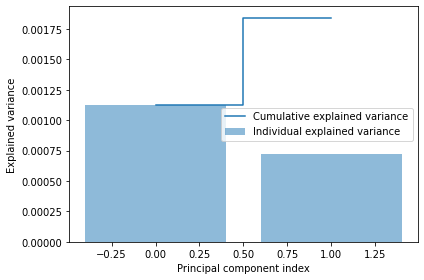

In [56]:
exp_var_pca = pca.explained_variance_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [57]:
distance.jaccard([1, 0, 0], [0, 1, 0])

distances = []
dataset = []

for rxn in rxnfp_dataset:
    indices = np.random.choice(rxnfp_dataset.shape[0], 25, replace=False)
    for rxn_alternative in rxnfp_dataset[indices]:
        distances.append(distance.jaccard(rxn, rxn_alternative))
        dataset.append("Ni-CO coupling")
        
for rxn in rxnfp_suzuki:
    indices = np.random.choice(rxnfp_suzuki.shape[0], 25, replace=False)
    for rxn_alternative in rxnfp_suzuki[indices]:
        distances.append(distance.jaccard(rxn, rxn_alternative))
        dataset.append("Suzuki HTE")
        
for rxn in rxnfp_bh:
    indices = np.random.choice(rxnfp_bh.shape[0], 25, replace=False)
    for rxn_alternative in rxnfp_bh[indices]:
        distances.append(distance.jaccard(rxn, rxn_alternative))
        dataset.append("Buchwald-Hartwig HTE")

df = pd.DataFrame(zip(distances, dataset), columns = ['Distance', 'Dataset',])

In [58]:
rxnfps = np.concatenate((rxnfp_dataset, rxnfp_suzuki, rxnfp_bh), axis=0)
labels = np.concatenate(([0] * len(rxnfp_dataset), [1] * len(rxnfp_suzuki), [2] * len(rxnfp_bh)))

#indices = np.random.choice(range(len(rxnfps)), 2500)
indices = range(len(rxnfps))
similarities = euclidean_distances(rxnfps[indices, :])

mds = MDS(
    n_components=2,
    max_iter=3,
    eps=1e-9,
    dissimilarity="precomputed")

pos = mds.fit(similarities).embedding_


In [59]:
pos *= np.sqrt((rxnfps[indices, :] ** 2).sum()) / np.sqrt((pos ** 2).sum())

In [60]:
projected_dataset = pos[np.where(labels[indices]==0)[0], :]
projected_suzuki = pos[np.where(labels[indices]==1)[0], :]
projected_bh = pos[np.where(labels[indices]==2)[0], :]

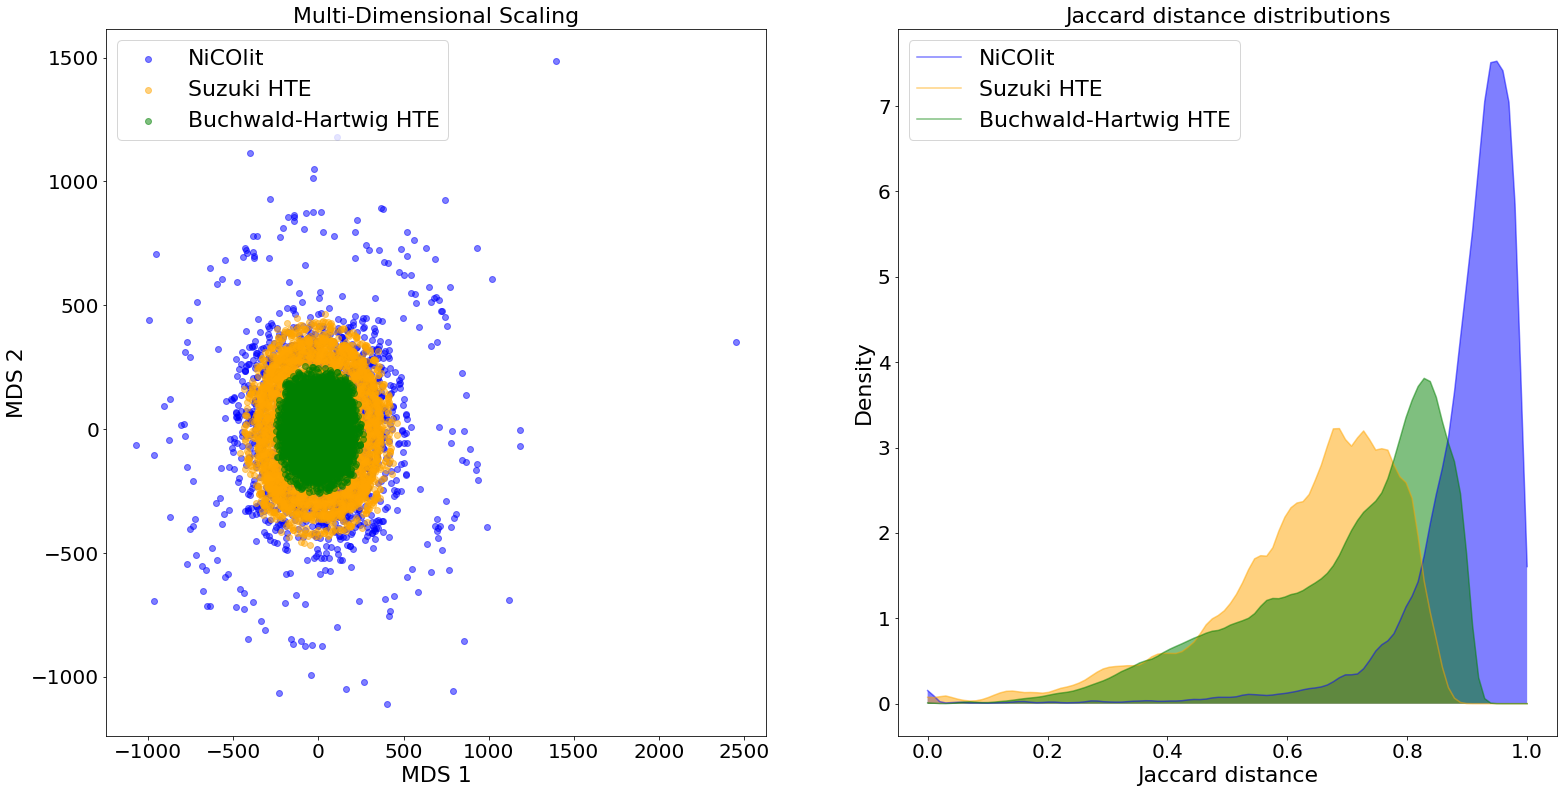

In [61]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(26, 13))

ax2.scatter(projected_dataset[:, 0], projected_dataset[:, 1], c='b', label="NiCOlit", alpha=0.5)
ax2.scatter(projected_suzuki[:, 0], projected_suzuki[:, 1], c='orange', label=classes[1], alpha=0.5)
ax2.scatter(projected_bh[:, 0], projected_bh[:, 1], c='g', label=classes[2], alpha=0.5)
ax2.set_title("Multi-Dimensional Scaling", fontsize=22)
ax2.set_xlabel("MDS 1", fontsize=22)
ax2.set_ylabel("MDS 2", fontsize=22)
#ax2.grid(True)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.legend(loc=2, fontsize=22)


x = np.array(distances)[np.where(np.array(dataset)=="Ni-CO coupling")[0]]
x_d = np.linspace(0, 1, 100)
density = sum(norm(xi, 0.01).pdf(x_d) for xi in x) / len(x)
ax3.fill_between(x_d, density, alpha=0.5, facecolor='b')
ax3.plot(x_d, density, color='b', label="NiCOlit", alpha=0.5)

x = np.array(distances)[np.where(np.array(dataset)=="Suzuki HTE")[0]]
x_d = np.linspace(0, 1, 100)
density = sum(norm(xi, 0.01).pdf(x_d) for xi in x) / len(x)
ax3.fill_between(x_d, density, alpha=0.5, facecolor='orange')
ax3.plot(x_d, density, color='orange', label="Suzuki HTE", alpha=0.5)

x = np.array(distances)[np.where(np.array(dataset)=="Buchwald-Hartwig HTE")[0]]
x_d = np.linspace(0, 1, 100)
density = sum(norm(xi, 0.01).pdf(x_d) for xi in x) / len(x)
ax3.fill_between(x_d, density, alpha=0.5, facecolor='g')
ax3.plot(x_d, density, color='g', label="Buchwald-Hartwig HTE", alpha=0.5)


#density = sum(norm(xi).pdf(x_d) for xi in x)
#plt.hist(np.array(distances)[np.where(np.array(dataset)=="Suzuki HTE")[0]], density=True, facecolor='b', alpha=0.5, label="Suzuki HTE")
#plt.hist(np.array(distances)[np.where(np.array(dataset)=="Buchwald-Hartwig HTE")[0]], density=True, facecolor='y', alpha=0.25, label="Buchwald-Hartwig HTE")

ax3.set_xlabel('Jaccard distance', fontsize=22)
ax3.set_ylabel('Density', fontsize=22)
ax3.set_title('Jaccard distance distributions', fontsize=22)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
#ax3.grid(True)
ax3.legend(loc=2, fontsize=22)


# 3. Accessible vs explored chemical space 

/opt/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


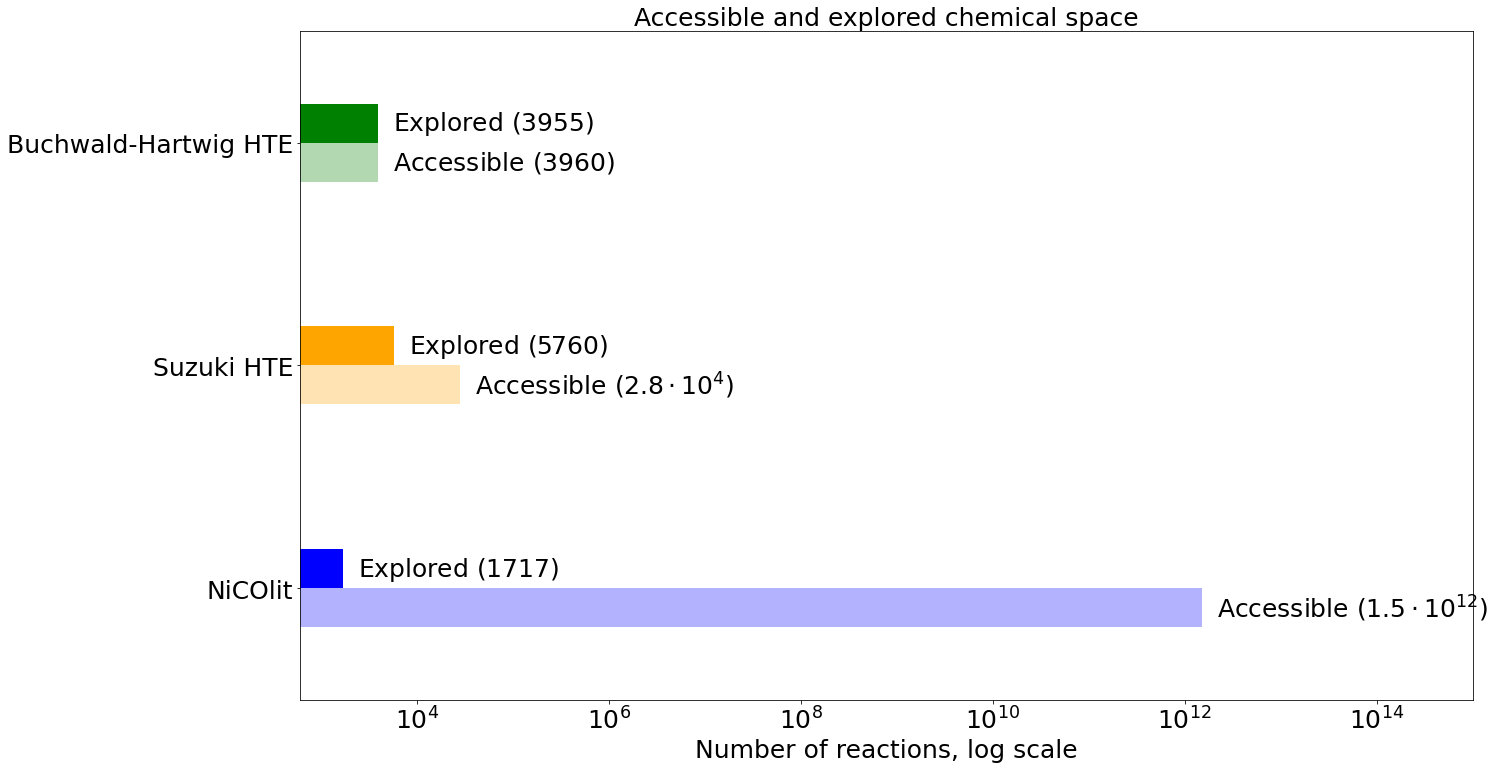

In [62]:
labels = ['NiCOlit', 'Suzuki HTE', 'Buchwald-Hartwig HTE',]

available_reactions = [1.5*1e12, 2.8*1e4, 3960]
available_reactions_labels = ["$1.5  \cdot 10^{12}$", "$2.8  \cdot 10^4$", "$3960$"]

existing_reactions = [1717, 5760, 3955]

existing_reactions_labels = ["$1717$", "$5760$", "$3955$"]


ind = np.arange(2* len(available_reactions), step=2) 

ind = np.array([1, 3, 5])
# the x locations for the groups
width = 0.35  # the width of the bars



fig, ax = plt.subplots(figsize = (20, 10))


rects1 = ax.barh(ind - width/2, available_reactions, width,
                label='Accessible reactions', color=["b", "orange", 'g'], alpha=0.3)
rects2 = ax.barh(ind + width/2, existing_reactions, width,  
                label='Explored reactions',color=["b", "orange", 'g'],)

# Add some text for labels, title and custom x-axis tick labels, etc.




for i, rect in enumerate(rects1):
    width = rect.get_width()
    x_value = rect.get_width() + rect.get_x()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 15 
    plt.annotate(
        "Accessible (" + available_reactions_labels[i] + ")",                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha="left", fontsize = 25)
    

    #plt.text(x_value, y_value, "Accessible" , ha='center', va='bottom', fontdict ={'fontsize': 25})

for i, rect in enumerate(rects2):
    width = rect.get_width()
    x_value = rect.get_width() + rect.get_x()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 15 
    plt.annotate(
        "Explored (" + existing_reactions_labels[i] + ")",                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha="left", fontsize = 25)

fig.tight_layout()

ax.set_xlabel('Number of reactions, log scale', fontdict ={'fontsize': 25})
ax.set_title('Accessible and explored chemical space', fontdict ={'fontsize': 25})
plt.xscale('log')
ax.set_ylim(0, 6)
ax.set_xlim(0, 1e15)

ax.set_yticks(ind)
ax.set_yticklabels(labels, fontdict ={'fontsize': 25})
ax.tick_params(axis='both', which='major', labelsize=25)


plt.show()

# 4. Yield distributions 

/opt/local/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 21.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/local/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 30.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/local/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 34.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/local/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 23.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/local/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: Us

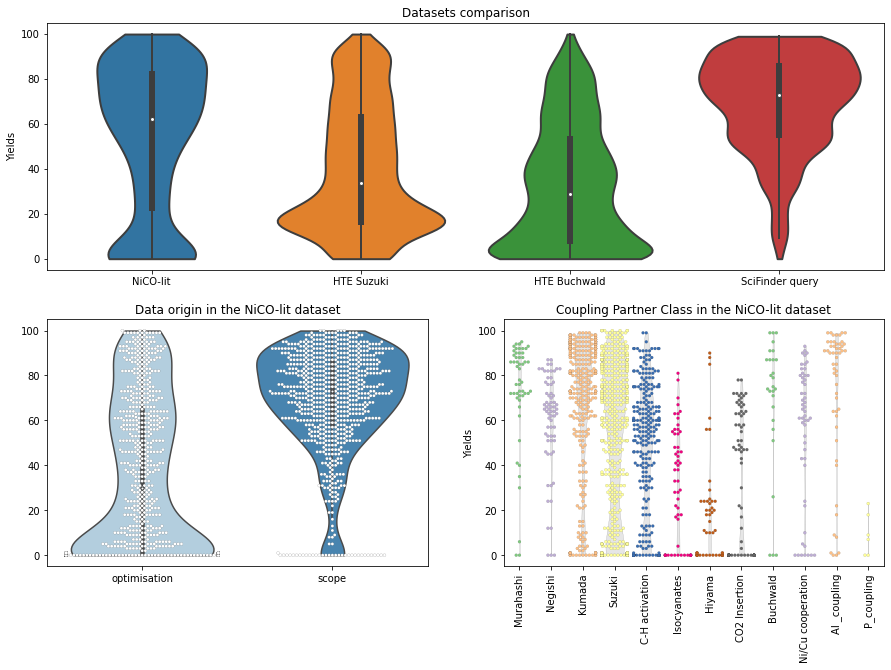

In [63]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))

# Comparison of the Yield distributions of the datasets
ax[0,1] = plt.subplot(211)
sns.violinplot(y="Yields", data=display_df2, x='Origin',  kind="swarm", cut=0, ax = ax[0,1], 
               linewidth=2) #scale='count')
for tick in ax[0,1].get_xticklabels():
    tick.set_rotation(0)
ax[0,1].set_title("Datasets comparison")
ax[0,1].set_xlabel("")

# Comparison of the Yield distributions of Scope and Optimization in the NiCOlit dataset
sns.swarmplot(ax=ax[1,0], y="Yields", data=display_df, x='Origin', color='white', s = 3, 
              linewidth=0.1, dodge=False, edgecolor='black', )
sns.violinplot(y="Yields", data=display_df, x='Origin',  kind="swarm", cut=0, 
               ax = ax[1,0], palette='Blues', scale='count')
ax[1,0].set_title("Data origin in the NiCO-lit dataset")
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("")

# Yield distributions of Different Class of Coupling Partner in the NiCOlit dataset
sns.swarmplot(ax=ax[1,1], y="Yields", data=display_df, x='Coupling Partner', palette='Accent', s = 3,
              linewidth=0.1, dodge=False)
sns.violinplot(ax=ax[1,1], y="Yields", data=display_df, x='Coupling Partner',
                    inner=None, color=".9", cut=0, scale='count', linewidth=0.2)

ax[1,1].set_title("Coupling Partner Class in the NiCO-lit dataset")

for tick in ax[1,1].get_xticklabels():
    tick.set_rotation(90)
ax[1,1].set_xlabel("")

plt.savefig('images/yields.svg', dpi=300, format='svg',
     bbox_inches='tight' )

# 5. Scope/optimization space 

/opt/local/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


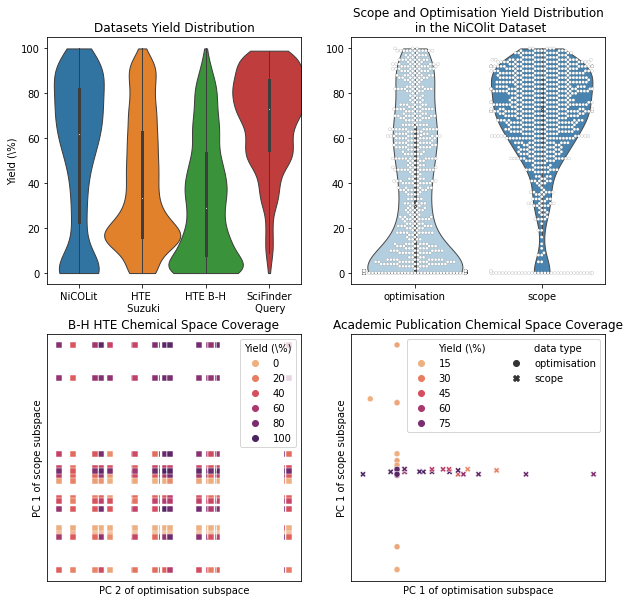

In [64]:
# Figure 2 
fig, ax = plt.subplots(2,2, figsize=(10, 10))

#ax[0,1] = plt.subplot(211)

# FIGURE COMP YIELDS DATASETS
sns.violinplot(y="Yields", data=display_df2, x='Origin',  
               kind="swarm", cut=0, ax = ax[0,0], 
               linewidth=1, width=1.2, inner="box") #scale='count')
for tick in ax[0,0].get_xticklabels():
    tick.set_rotation(0)
ax[0,0].set_title("Datasets Yield Distribution")
ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("Yield (\%)")
ax[0,0].set_xticklabels(["NiCOLit", "HTE \n Suzuki", "HTE B-H", "SciFinder\n Query"])


# FIGURE SCOPE/OPT
sns.swarmplot(ax=ax[0,1], y="Yields", data=display_df, x='Origin', color='white', s = 3, 
              linewidth=0.1, dodge=False, edgecolor='black', 
             )
sns.violinplot(y="Yields", data=display_df, x='Origin',  kind="swarm", cut=0, 
               ax = ax[0,1], palette='Blues', scale='count',
              linewidth=1)
ax[0,1].set_title("Scope and Optimisation Yield Distribution\n in the NiCOlit Dataset")
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")


# FIGURE SCOPE/OPT in HTE
sns.scatterplot(x='opt', y='sco', hue='yield', data=data_hte, marker="s",
                legend="auto", ax = ax[1,0], palette='flare')

ax[1,0].set_title("B-H HTE Chemical Space Coverage")
ax[1,0].legend(title="Yield (\%)", loc = 'upper right')
ax[1,0].set_xlabel("PC 2 of optimisation subspace")
ax[1,0].set_ylabel("PC 1 of scope subspace")
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
handles0 = ax[1,0].get_legend_handles_labels()

# FIGURE SCOPE/OPT in NiCOLit
sns.scatterplot(data=data_doi, x='proj_scope', y='proj_optimisation', 
                hue='yield', ax = ax[1,1], style="data type", legend="auto",
                palette='flare')
ax[1,1].set_title("Academic Publication Chemical Space Coverage")
ax[1,1].set_xlabel("PC 1 of optimisation subspace")
ax[1,1].set_ylabel("PC 1 of scope subspace")
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

handles = ax[1,1].get_legend_handles_labels()
h0 = handles[0] 
h0.append(handles[0][0])
h0.append(handles[0][0])
h1 = ['Yield (\%)', '15', '30', '45', '60', '75', 'data type', 'optimisation', 'scope', '', '']
ax[1,1].get_legend().remove()
ax[1,1].legend(h0, h1, ncol=2, loc='upper right')

plt.savefig('images/figure2.svg', dpi=600, format='svg',
     bbox_inches='tight' )